In [1]:
# # # importing data onto Google Colab
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
import math
import h5py
import numpy as np
import netCDF4 as nc
#from netCDF4 import Dataset
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib.pyplot as plt
import time
import pandas as pd
import datetime
import random
import copy

import os
import torch
print(torch.__version__)
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import from_numpy
from torch import manual_seed as torch_manual_seed
from torch.cuda import max_memory_allocated, set_device, manual_seed_all
from torch.backends import cudnn
import torch.optim as optim


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
from functools import partial

2.1.0a0+29c30b1


In [3]:
class Net(nn.Module):
    def __init__(self, p, p2d):
        super(Net, self).__init__()
        self.p = p
        self.p2d = p2d
        self.conv1 = nn.Conv2d(1, 32, stride = (3,3), kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, stride = (2,2), kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 4 * 6, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)  # 1 output value
        self.dropout2d = nn.Dropout2d(p = self.p2d)
        self.dropout = nn.Dropout(p = self.p)

    def forward(self, x):
        x = self.pool(torch.nn.functional.leaky_relu(self.conv1(x)))
        x = self.dropout2d(x)
        x = self.pool(torch.nn.functional.leaky_relu(self.conv2(x)))
        x = self.dropout2d(x)
        x = self.pool(torch.nn.functional.leaky_relu(self.conv3(x)))
        x = x.view(-1, 8 * 4 * 6)
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.nn.functional.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x

model=Net(0.1, 0.1)
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=192, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (dropout2d): Dropout2d(p=0.1, inplace=False)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [4]:
ds3 = xr.open_dataset("real_world_sst.nc", decode_times=False)
#ds2 = xr.open_dataset("/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_SST.nc", decode_times=False)
ds3

<xarray.Dataset> Size: 32MB
Dimensions:  (time: 72, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) int64 576B 0 365 730 1096 1461 ... 24837 25202 25567 25933
Data variables:
    SST      (time, lat, lon) float64 32MB ...

In [5]:
PRECT_real = pd.read_csv('real_world_prect.csv')
#PRECT = pd.read_csv('/content/drive/MyDrive/CaliforniaClimateCapstone/Data/Detrended_PRECT.csv')
PRECT_real = PRECT_real.set_index(['year', 'region'])
PRECT_real.drop(columns=['Unnamed: 0'], inplace=True)
PRECT_real.head()

,,PRECT
year,region,
1950,North,-1.252478
1951,North,6.405958
1952,North,0.244133
1953,North,-1.394033
1954,North,-9.740346


In [6]:
PRECT_real.iloc[144:]

,,PRECT
year,region,
1950,South,-3.861093
1951,South,3.997832
1952,South,-1.571997
1953,South,0.323647
1954,South,-1.887663
...,...,...
2017,South,-3.404232
2018,South,3.063811
2019,South,0.466426


In [7]:
y= PRECT_real.to_numpy()
y.shape

(216, 1)

In [8]:
y = y[144:]
y.shape

(72, 1)

In [9]:
X = ds3['SST'].to_numpy()

In [10]:
X = X[:72, :, :]
X.shape

(72, 192, 288)

In [11]:
def setup_seed(seed):
    torch_manual_seed(seed)
    manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    cudnn.deterministic = True

SEED = 42
setup_seed(SEED)

In [12]:
BATCH_SIZE = 32
X_train = X[:40,:,:]
X_test = X[40:, :, :]
y_train = y[:40,:]
y_test = y[40:, :]

X_train = from_numpy(X_train).float()
y_train = from_numpy(y_train).float()

X_test = from_numpy(X_test).float()
y_test = from_numpy(y_test).float()

X_train = X_train.view(-1, 192, 288)
y_train = y_train.view(-1, 1)

X_test = X_test.view(-1, 192, 288)
y_test = y_test.view(-1, 1)

dataset_train = TensorDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False)
dataset_test = TensorDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)


In [13]:
train_losses = []
valid_losses = []

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    epoch_loss = 0  # Initialize epoch loss
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X = X.unsqueeze(1)
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        # Compute prediction and loss
        pred = model(X)

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

        if batch % 36 == 0:
            loss, current = loss.item(), batch * BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    epoch_avg_loss = epoch_loss / num_batches
    train_losses.append(epoch_avg_loss)


def test_valid_loop(dataloader, model, loss_fn, valid = True):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            # Prepare Data
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            X = X.unsqueeze(1)
            # make predictions and calculate loss and accuracy
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches

    # Print either Validation or Test error
    if valid:
      print(f"Validation Loss: {test_loss:>8f} \n")
      valid_losses.append(test_loss)
    else:
      print(f"Test Loss: {test_loss:>8f} \n")

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Train model and evaluate on validation set for each epoch

# Optimal values from performance:
tuned_p = 0.01
tuned_p2 = 0.01
tuned_lr = 0.01

model = Net(tuned_p, tuned_p2)
#model = Net(tuned_p)
model.to(device)

# Freeze all layers except the final FC layer
for param in model.parameters():
    param.requires_grad = False

# Set requires_grad=True for parameters in the final FC layer
for param in model.fc3.parameters():
    param.requires_grad = True

#ADD PATH FOR BEST MODEL WEIGHTS
model.load_state_dict(torch.load('South_Final_Weights_Sim.pth', map_location=device))

# Optionally, you might want to move your model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=tuned_lr)
epochs = 200

best_loss = np.inf
#patience = 30
#no_improvement_counter = 0

train_losses = []
valid_losses = []

for t in range(epochs):

    # if no_improvement_counter >= patience:
    #     break

    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader_train, model, loss_fn, optimizer)
    #test_valid_loop(dataloader_valid, model, loss_fn)

    # if valid_losses[t] < best_loss:
    #     best_loss = valid_losses[t]
    #     no_improvement_counter = 0
    #     best_model_weights = copy.deepcopy(model.state_dict())
    # else:
    #     no_improvement_counter += 1

print("Done!")

Epoch 1
-------------------------------
loss: 9.558455  [   32/   40]
Epoch 2
-------------------------------
loss: 9.449639  [   32/   40]
Epoch 3
-------------------------------
loss: 9.477272  [   32/   40]
Epoch 4
-------------------------------
loss: 9.436763  [   32/   40]
Epoch 5
-------------------------------
loss: 9.323397  [   32/   40]
Epoch 6
-------------------------------
loss: 9.473352  [   32/   40]
Epoch 7
-------------------------------
loss: 9.448728  [   32/   40]
Epoch 8
-------------------------------
loss: 9.353976  [   32/   40]
Epoch 9
-------------------------------
loss: 9.426517  [   32/   40]
Epoch 10
-------------------------------
loss: 9.446568  [   32/   40]
Epoch 11
-------------------------------
loss: 9.427455  [   32/   40]
Epoch 12
-------------------------------
loss: 9.461164  [   32/   40]
Epoch 13
-------------------------------
loss: 9.497093  [   32/   40]
Epoch 14
-------------------------------
loss: 9.511008  [   32/   40]
Epoch 15
------

In [16]:
def r_squared(actual, predicted):
    # Calculate mean of actual values
    mean_actual = np.mean(actual)

    # Calculate sum of squared differences between actual and predicted values
    ss_residual = np.sum((actual - predicted) ** 2)

    # Calculate sum of squared differences between actual and mean values
    ss_total = np.sum((actual - mean_actual) ** 2)

    # Calculate R-squared
    r2 = 1 - (ss_residual / ss_total)

    return r2


actual_values = np.array(y_test.squeeze(1))

# # Instantiate model
# model_best_weights = Net(tuned_p, tuned_p)
# model_best_weights.to(device)

# # Load the best model weights
# model_best_weights.load_state_dict(best_model_weights)

#model_best_weights.load_state_dict(torch.load('12kparams_model_weights_r2_1434.pth', map_location=device))

X_test.to(device)
# Set the model to evaluation mode
#model_best_weights.eval()
model.eval()
#predicted_values = model_best_weights(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()
predicted_values = model(X_test.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()

r_squared_value = r_squared(actual_values, predicted_values)
print("R-squared:", r_squared_value)

# torch.save(model.state_dict(), 'South_Final_Weights_Real_World.pth')

R-squared: 0.33582013845443726


R2: 0.33582013845443726

Inital weights: from R2 of leaky relu 50 epoch 12k model

Bias: Yes

Pooling: Max

Relu: leaky

Epochs: 200

tuned_p = 0.01

tuned_p2 = 0.01

tuned_lr = 0.01

In [17]:
pred_dict = dict()
pred_dict2 = dict()

for i in range(32):
    pred_dict[i] = actual_values[i]
    pred_dict2[i] = predicted_values[i]

actual_df = pd.DataFrame(list(pred_dict.items()), columns=['Year', 'Actual PRECT'])
pred_df = pd.DataFrame(list(pred_dict2.items()), columns=['Year', 'Predicted PRECT'])

# Merge the DataFrames on 'Epoch' column
actual_pred_df = pd.merge(actual_df, pred_df, on='Year')

#actual_pred_df


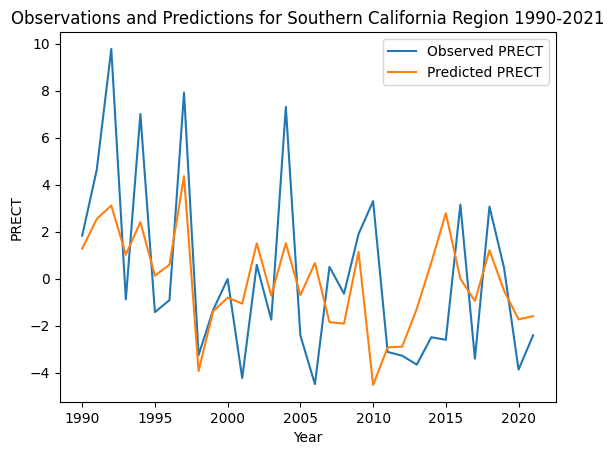

In [18]:
plt.plot(actual_pred_df['Year'] + 1990, actual_pred_df['Actual PRECT'], label='Observed PRECT')
plt.plot(actual_pred_df['Year'] + 1990, actual_pred_df['Predicted PRECT'], label='Predicted PRECT')
plt.xlabel('Year')
plt.ylabel('PRECT')
plt.title('Observations and Predictions for Southern California Region 1990-2021')
plt.legend()
plt.show()

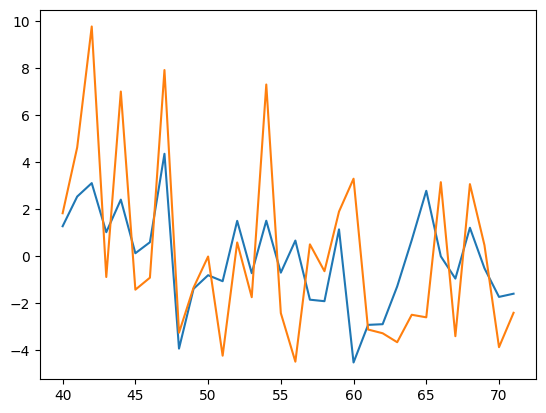

In [19]:
# Get Y pred predictions
predicted_train_values = model(X_train.unsqueeze(1).to(device)).squeeze(1).detach().cpu().numpy()

all_predictions = pd.DataFrame(list(predicted_train_values) + list(predicted_values)).rename({0: "predicted_values"}, axis=1)

plt.plot(range(40,72), all_predictions[40:]['predicted_values'], label='Observed PRECT')
plt.plot(range(40,72), y[40:], label='Actual PRECT')

#all_predictions.to_csv("all_predictions_south.csv")

In [20]:
differences_years = (all_predictions - y).reset_index()

differences_years['index'] = 1950 + differences_years['index'] 

differences_years.sort_values('predicted_values').head(50)

,index,predicted_values
27,1977,-9.170663
60,2010,-7.817383
29,1979,-7.153990
42,1992,-6.662711
54,2004,-5.794204
32,1982,-5.446324
44,1994,-4.597979
18,1968,-4.113261
28,1978,-3.725174
11,1961,-3.582796


In [21]:
actual_pred_df

,Year,Actual PRECT,Predicted PRECT
0,0,1.826548,1.274111
1,1,4.627570,2.535867
2,2,9.770876,3.108165
3,3,-0.886098,1.020098
4,4,7.003431,2.405453
5,5,-1.424770,0.125183
6,6,-0.915782,0.592749
7,7,7.918124,4.355339
8,8,-3.255273,-3.931000
9,9,-1.337958,-1.388306


In [22]:
X_test[9].shape

torch.Size([192, 288])

/home/mtv2eva/.local/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1356: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


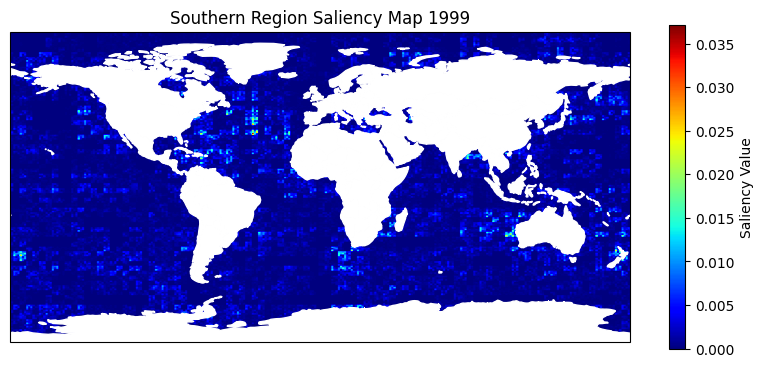

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from PIL import Image
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader
import torch
import numpy as np
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from captum.attr import Saliency
from captum.attr import visualization as viz
from PIL import Image

longitude = ds3['lon'].values
latitude = ds3['lat'].values
# Generate a sample input tensor
input_data = X_test[9].unsqueeze(0)  # Example input data

input_data = input_data.to(device) 

# Create a Saliency object for your model
saliency = Saliency(model)

# Compute the saliency map
saliency_map = saliency.attribute(input_data)

# Convert saliency map to NumPy array
saliency_map_np = saliency_map.cpu().detach().numpy()

saliency_map_np = np.flipud(saliency_map_np.squeeze())

# Resize the saliency map to match latitude and longitude dimensions
saliency_map_resized = np.array(Image.fromarray(saliency_map_np).resize((len(longitude), len(latitude))))

# Add cyclic point to the data
saliency_map_cyclic, longitude_cyclic = add_cyclic_point(saliency_map_resized, coord=longitude)

# Plot the saliency map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Overlay the saliency map
img = ax.imshow(saliency_map_cyclic, origin='upper', extent=[longitude_cyclic.min(), longitude_cyclic.max(), latitude.min(), latitude.max()], transform=ccrs.PlateCarree(), cmap='jet')

# Add country outlines and fill them in white
shpfilename = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

for country in countries:
    ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor='white', edgecolor='white')

cbar = plt.colorbar(img, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label('Saliency Value')

plt.title('Southern Region Saliency Map 1999')
plt.show()